Generating elbow plot to find optimal k...


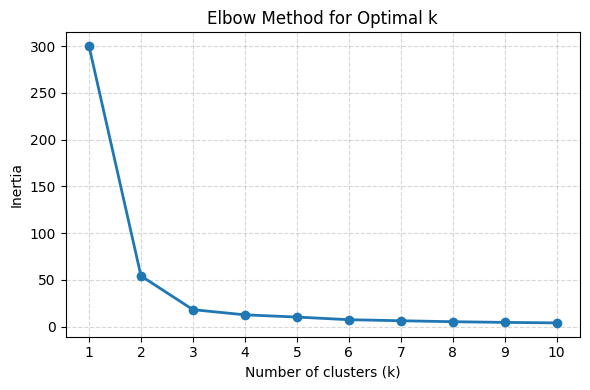

Choosing k = 3 (you can adjust this based on the plot).


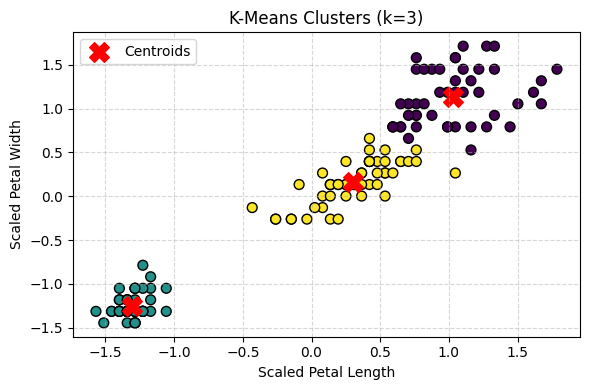

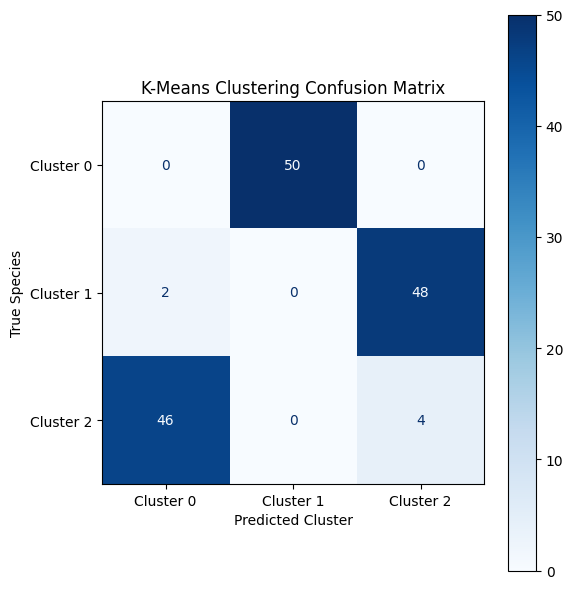


Confusion Matrix (counts):
                       Cluster 0  Cluster 1  Cluster 2
True: Iris-setosa              0         50          0
True: Iris-versicolor          2          0         48
True: Iris-virginica          46          0          4


In [ ]:
#!/usr/bin/env python3
# kmeans_iris.py
# --------------------------------------------------
# Implements K-Means clustering on the Iris dataset,
# using petal length & width. Includes elbow plot
# for selecting k and a confusion matrix against true species.
# --------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def load_data(csv_path='iris.csv'):
    """
    Try loading from csv_path; if not found, load via sklearn.
    Expects columns: sepal_length, sepal_width, petal_length, petal_width, species.
    Returns DataFrame with a 'species' column.
    """
    try:
        df = pd.read_csv(csv_path)
        # Fixed typo here: use c.strip().replace, not ace()
        df.columns = [c.strip().replace(' ', '_') for c in df.columns]
    except FileNotFoundError:
        iris = load_iris()
        df = pd.DataFrame(
            data=np.c_[iris['data'], iris['target']],
            columns=iris['feature_names'] + ['target']
        )
        df.columns = [c.strip().replace(' (cm)', '').replace(' ', '_')
                      for c in df.columns]
        df['species'] = df['target'].map(lambda x: iris['target_names'][int(x)])
    return df

def preprocess(df):
    """
    Select only petal_length & petal_width, then standard-scale.
    Returns scaled numpy array.
    """
    X = df[['petal_length', 'petal_width']].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

def plot_elbow(X_scaled, max_k=10):
    """
    Compute KMeans inertia for k=1..max_k and plot the elbow curve.
    Returns list of inertias.
    """
    inertias = []
    ks = range(1, max_k + 1)
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_scaled)
        inertias.append(km.inertia_)
    plt.figure(figsize=(6, 4))
    plt.plot(ks, inertias, 'o-', linewidth=2)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.xticks(ks)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    return inertias

def run_kmeans(X_scaled, k):
    """
    Fit KMeans with k clusters, return labels and fitted model.
    """
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    return km, labels

def plot_confusion(df, labels, k):
    """
    Builds and displays a confusion matrix comparing true species vs. cluster.
    """
    species_names = df['species'].unique()
    species_to_num = {name: idx for idx, name in enumerate(species_names)}
    true_nums = df['species'].map(species_to_num)

    cm = confusion_matrix(true_nums, labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[f"Cluster {i}" for i in range(k)]
    )
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='Blues', colorbar=True)
    ax.set_xlabel('Predicted Cluster')
    ax.set_ylabel('True Species')
    plt.title('K-Means Clustering Confusion Matrix')
    plt.tight_layout()
    plt.show()

    cm_df = pd.DataFrame(
        cm,
        index=[f"True: {name}" for name in species_names],
        columns=[f"Cluster {i}" for i in range(k)]
    )
    print("\nConfusion Matrix (counts):")
    print(cm_df)

def main():
    # 1) Load data
    df = load_data('iris.csv')
    if 'species' not in df.columns:
        print("Error: 'species' column not found.")
        return

    # 2) Preprocess
    X_scaled, scaler = preprocess(df)

    # 3) Elbow plot to decide k
    print("Generating elbow plot to find optimal k...")
    inertias = plot_elbow(X_scaled, max_k=10)

    # 4) From the elbow you’ll typically see a bend at k=3
    optimal_k = 3
    print(f"Choosing k = {optimal_k} (you can adjust this based on the plot).")

    # 5) Run K-Means and assign clusters
    km_model, labels = run_kmeans(X_scaled, optimal_k)
    df['cluster'] = labels

    # 6) Visualize clusters in feature space
    plt.figure(figsize=(6, 4))
    plt.scatter(
        X_scaled[:, 0], X_scaled[:, 1],
        c=labels, cmap='viridis', edgecolor='k', s=50
    )
    centroids = km_model.cluster_centers_
    plt.scatter(
        centroids[:, 0], centroids[:, 1],
        marker='X', c='red', s=200, label='Centroids'
    )
    plt.xlabel('Scaled Petal Length')
    plt.ylabel('Scaled Petal Width')
    plt.title(f'K-Means Clusters (k={optimal_k})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 7) Confusion matrix vs. true species
    plot_confusion(df, labels, optimal_k)

if __name__ == "__main__":
    main()
